In [1]:
# Cell 1: Setup and imports
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'  # You can change to 'jax' or 'torch' if preferred

import numpy as np
import keras
import sentencepiece as spm

print(f"Keras version: {keras.__version__}")
print(f"Keras backend: {keras.config.backend()}")

Keras version: 3.10.0
Keras backend: tensorflow


In [2]:
# Cell 2: Load and prepare text data
# Load the Kalevala text
with open('./kalevala_puhdas.txt', 'r', encoding='utf-8-sig') as file:
    text = file.read()

print(f"Text length: {len(text)} characters")
print(f"First 100 characters: {text[:100]}")

Text length: 545594 characters
First 100 characters: Ensimmäinen runo


Mieleni minun tekevi,
aivoni ajattelevi
lähteäni laulamahan,
saa'ani sanelemahan,


In [3]:
# Cell 3: Train SentencePiece model
# Save text to a temporary file for SentencePiece training
temp_file = 'kalevala_temp.txt'
with open(temp_file, 'w', encoding='utf-8') as f:
    f.write(text)

# Train SentencePiece model
vocab_size = 10000  # You can adjust this based on your needs
model_prefix = 'kalevala_sp'

spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=1.0,  # Important for Finnish
    model_type='bpe',
    user_defined_symbols=['<PAD>', '<UNK>']
)

# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# Test tokenization
test_text = "Vaka vanha Väinämöinen"
tokens = sp.encode_as_pieces(test_text)
print(f"Tokenized example: {tokens}")
print(f"Vocabulary size: {sp.get_piece_size()}")

Tokenized example: ['▁Vaka', '▁vanha', '▁Väinämöinen']
Vocabulary size: 10000


In [4]:
# Cell 4: Prepare training data
# Tokenize the text
seq_length = 64
pieces = sp.encode_as_ids(text)
print(f"Total tokens: {len(pieces)}")

# Create sequences
sequences = []
for i in range(0, len(pieces) - seq_length):
    # Input: first seq_length tokens, Target: next seq_length tokens (shifted by 1)
    sequences.append(pieces[i:i+seq_length+1])

# Convert to NumPy arrays
sequences = np.array(sequences)
inputs = sequences[:, :-1]  # All tokens except the last one
targets = sequences[:, 1:]  # All tokens except the first one

print(f"Number of sequences: {len(sequences)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

# Split into training and validation sets
indices = np.arange(len(sequences))
np.random.shuffle(indices)

train_size = int(0.8 * len(sequences))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_inputs, train_targets = inputs[train_indices], targets[train_indices]
val_inputs, val_targets = inputs[val_indices], targets[val_indices]

Total tokens: 119158
Number of sequences: 119094
Input shape: (119094, 64)
Target shape: (119094, 64)


In [5]:
# Cell 5: Define the model
def get_positional_encoding(max_len, d_model):
    """Create sinusoidal positional encoding."""
    positions = np.arange(max_len)[:, np.newaxis]
    angles = np.arange(d_model)[np.newaxis, :] / d_model
    angles = 1 / (10000**angles)

    pos_encoding = positions * angles
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return pos_encoding

# Define model parameters
embed_dim = 192
num_heads = 4
ff_dim = 384
num_layers = 2

# Create the model
inputs = keras.Input(shape=(seq_length,))
embedding_layer = keras.layers.Embedding(sp.get_piece_size(), embed_dim)(inputs)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_length, embed_dim)
x = embedding_layer + pos_encoding

# Transformer blocks
for _ in range(num_layers):
    # Multi-head attention with causal mask
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=0.1
    )(x, x, use_causal_mask=True)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ffn = keras.Sequential([
        keras.layers.Dense(ff_dim, activation="relu"),
        keras.layers.Dense(embed_dim),
        keras.layers.Dropout(0.1)
    ])
    ffn_output = ffn(x)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

# Final output layer
outputs = keras.layers.Dense(sp.get_piece_size())(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 192)   │  1,920,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 192)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 192)   │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 192)   │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 192)   │    148,032 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 192)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 192)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 192)   │    148,032 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 192)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 10000) │  1,930,000 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,444,048 (16.95 MB)

 Trainable params: 4,444,048 (16.95 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6: Train the model
batch_size = 128
epochs = 100

history = model.fit(
    train_inputs, train_targets,
    validation_data=(val_inputs, val_targets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
        keras.callbacks.ModelCheckpoint('kalevala_best_model.keras', save_best_only=True)
    ]
)

Epoch 1/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 90s 77ms/step - accuracy: 0.1113 - loss: 8.2407 - val_accuracy: 0.1226 - val_loss: 7.5249 - learning_rate: 5.0000e-05
Epoch 2/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.1279 - loss: 7.4272 - val_accuracy: 0.1676 - val_loss: 6.7074 - learning_rate: 5.0000e-05
Epoch 3/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.1770 - loss: 6.5217 - val_accuracy: 0.2062 - val_loss: 5.9204 - learning_rate: 5.0000e-05
Epoch 4/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.2120 - loss: 5.8410 - val_accuracy: 0.2436 - val_loss: 5.3237 - learning_rate: 5.0000e-05
Epoch 5/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.2474 - loss: 5.2802 - val_accuracy: 0.2746 - val_loss: 4.7830 - learning_rate: 5.0000e-05
Epoch 6/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.2753 - loss: 4.7742 - val_accuracy: 0.2952 - val_loss: 4.3298 - learning_rate: 5.0000e-05
Epoch 7/100
745/745 ━━━━━━━━━━━━━━━━━━━━ 26s 3

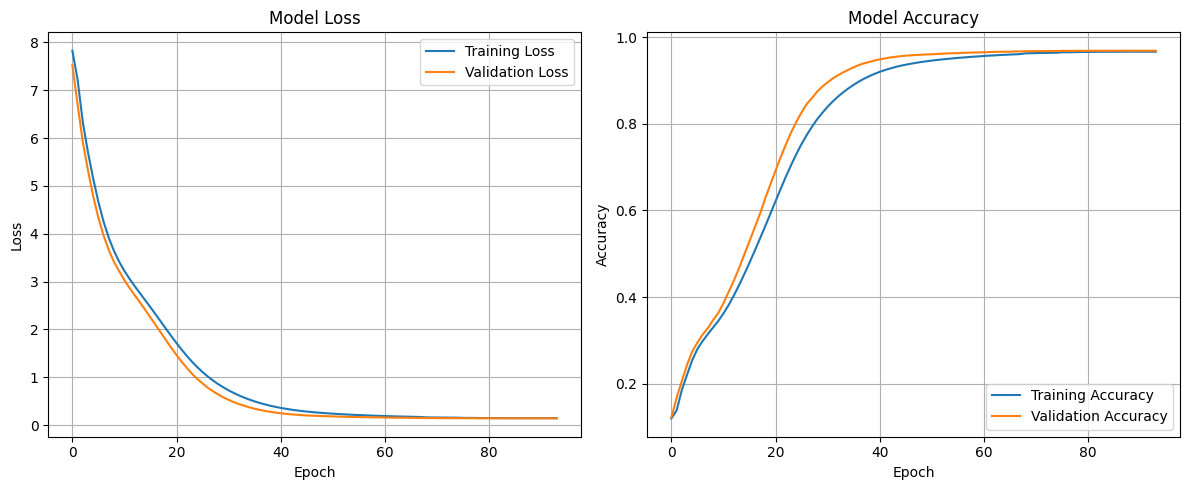

In [12]:
# Cell 7: Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Cell 8: Save the model
model.save('kalevala_model.keras')
print("Model saved as 'kalevala_model.keras'")

Model saved as 'kalevala_model.keras'


In [14]:
def generate_text(model, sp, prompt, num_tokens=100, temperature=1.0):
    """
    Generate text autoregressively.

    Args:
        temperature: Controls randomness
            - Low (0.1-0.5): Focused, repetitive
            - Medium (0.7-1.0): Balanced
            - High (1.5+): Creative, chaotic
    """
    # Encode the prompt
    input_ids = sp.encode_as_ids(prompt)

    # Rest of your generation code stays the same...
    if len(input_ids) < seq_length:
        padding_length = seq_length - len(input_ids)
        input_ids = [0] * padding_length + input_ids
    else:
        padding_length = 0
        input_ids = input_ids[-seq_length:]

    # Generated tokens
    generated_ids = list(input_ids[padding_length:])

    # Generate text token by token
    for _ in range(num_tokens):
        x = np.array([input_ids])
        predictions = model.predict(x, verbose=0)[0]
        logits = predictions[-1]
        logits = logits / temperature
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)
        next_token = np.random.choice(len(probs), p=probs)
        generated_ids.append(next_token)
        input_ids = input_ids[1:] + [next_token]

    # Decode the generated sequence
    generated_text = sp.decode(generated_ids)

    return generated_text

In [15]:
# Cell 10: Generate sample text
prompts = [
    "Vaka vanha Väinämöinen",
    "Mieleni minun tekevi",
    "Lemminkäinen",
    "Pohjan neito"
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    generated = generate_text(model, sp, prompt, num_tokens=100, temperature=1.2)
    print(generated)


Prompt: Vaka vanha Väinämöinen
Vaka vanha Väinämöinen jalan pyörti taivahalle, laittoi lapsen helmahansa. Piilyivät tullehelta, sanoivat sanalla tuolla: "Ku sanoma kurjan miehen, tuuma uinehen urohon?" Vaka vanha Väinämöinen sanan virkkoi, noin nimesi: "Kuusta on sanomat kummat, päivästä iki-imehet. Minnes meiltä päivä päätyi, kunnes meiltä kuu katosi?" Pohjan poikaset sanovi, paha parvi lausueli: "Tuonne teiltä päivä päätyi, päivä päätyi, kuu katosi kirjarintahan kivehen, rautaisehen kalliohon. Sielt' ei

Prompt: Mieleni minun tekevi
Mieleni minun tekevi juomahan soan tuloa, soan tulahojen, jos sen oli kylki kylmimässä, oli hyyksi hyytymässä, meren jääksi jäätymässä, kiveksi kovoamassa. Sanoi seppo Ilmarinen: "Ei tämä hyvä minulle! Vienen neien Väinölähän Väinämöiselle varaksi, polviseksi puolisoksi, kainaloiseksi kanaksi?" Tuopa kaunis Pohjan tytti itse ennätti sanoa: "Mi sinä lienet miehiäsi ja kuka urohiasi? Verta on seitsemän venettä, kantokorvoa kaheksan sun, poloinen, polvestas

In [11]:
# Cell 11: Load model (if you're starting a new session)
# Uncomment these lines to load a previously saved model
"""
# Load saved model
model = keras.models.load_model('kalevala_model.keras')

# Load SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load('kalevala_sp.model')

# Test generation
prompt = "Mieleni minun tekevi"
generated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)
print(generated)
"""

'\n# Load saved model\nmodel = keras.models.load_model(\'kalevala_model.keras\')\n\n# Load SentencePiece tokenizer\nsp = spm.SentencePieceProcessor()\nsp.load(\'kalevala_sp.model\')\n\n# Test generation\nprompt = "Mieleni minun tekevi"\ngenerated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)\nprint(generated)\n'